Suburb Distance from City

In [14]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# -----------------------------
# Step 1: Load suburb centroids
# -----------------------------
clusters_df = pd.read_csv(
    "/Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/raw/mapped_target_suburbs.csv"
)

clusters_gdf = gpd.GeoDataFrame(
    clusters_df,
    geometry=gpd.points_from_xy(clusters_df["Lng"], clusters_df["Lat"]),
    crs="EPSG:4326"  # WGS84 (lat/lon)
)

# -----------------------------
# Step 2: Define Melbourne CBD point
# -----------------------------
# Approx Melbourne CBD (Flinders St Station)
cbd_point = gpd.GeoSeries([Point(144.9631, -37.8136)], crs="EPSG:4326")

# -----------------------------
# Step 3: Reproject to meters for distance calculation
# -----------------------------
clusters_gdf_m = clusters_gdf.to_crs(epsg=7856)  # GDA2020 / VicGrid (meters)
cbd_point_m = cbd_point.to_crs(epsg=7856)

# -----------------------------
# Step 4: Calculate distance (km)
# -----------------------------
clusters_gdf_m["dist_to_cbd_km"] = clusters_gdf_m.distance(cbd_point_m[0]) / 1000

# -----------------------------
# Step 5: Save results
# -----------------------------
output_path = "suburb_distance_from_cbd.csv"
clusters_gdf_m.drop(columns="geometry").to_csv(output_path, index=False)

print("✅ Distance from CBD saved:", output_path)
print(clusters_gdf_m[["Matched_Cluster", "dist_to_cbd_km"]].head())


✅ Distance from CBD saved: suburb_distance_from_cbd.csv
                       Matched_Cluster  dist_to_cbd_km
0         Albert Park; St Kilda - West        4.496122
1                             Armadale        7.015212
2                              Carlton        1.520583
3                   Carlton; Parkville        2.231578
4  Melbourne CBD - East; St Kilda East        3.444661


In [10]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# -----------------------------
# Step 1: Load rentals dataset
# -----------------------------
rentals_df = pd.read_csv(
    "/Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/landing/domain/Data/vic_rentals_all.csv"
)

rentals_gdf = gpd.GeoDataFrame(
    rentals_df,
    geometry=gpd.points_from_xy(rentals_df["lon"], rentals_df["lat"]),
    crs="EPSG:4326"  # WGS84 (lat/lon)
)

# -----------------------------
# Step 2: Define Melbourne CBD
# -----------------------------
cbd_point = gpd.GeoSeries([Point(144.9631, -37.8136)], crs="EPSG:4326")

# -----------------------------
# Step 3: Reproject to meters for distance calc
# -----------------------------
rentals_gdf_m = rentals_gdf.to_crs(epsg=7856)  # GDA2020 / VicGrid (meters)
cbd_point_m = cbd_point.to_crs(epsg=7856)

# -----------------------------
# Step 4: Calculate distance (km)
# -----------------------------
rentals_gdf_m["dist_to_cbd_km"] = rentals_gdf_m.distance(cbd_point_m[0]) / 1000

# -----------------------------
# Step 5: Save updated dataset
# -----------------------------
output_path = "/Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/landing/domain/Data/vic_rentals_all_with_distance.csv"
rentals_gdf_m.drop(columns="geometry").to_csv(output_path, index=False)

print("✅ Updated rentals dataset with distance saved:", output_path)
print(rentals_gdf_m[["suburb", "weekly_rent", "dist_to_cbd_km"]].head())


✅ Updated rentals dataset with distance saved: /Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/landing/domain/Data/vic_rentals_all_with_distance.csv
             suburb  weekly_rent  dist_to_cbd_km
0  SOUTH KINGSVILLE        460.0        8.391711
1  SOUTH KINGSVILLE        400.0        8.578562
2  SOUTH KINGSVILLE        795.0        8.793755
3  SOUTH KINGSVILLE        675.0        8.590282
4  SOUTH KINGSVILLE        450.0        8.548941


sa2 level rent



In [ ]:
import pandas as pd
import geopandas as gpd

# -----------------------------
# Load rentals
# -----------------------------
rentals = pd.read_csv(
    "/Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/landing/domain/Data/vic_rentals_all_with_distance.csv"
)

# Make sure rent is numeric
rentals["weekly_rent"] = pd.to_numeric(rentals["weekly_rent"], errors="coerce")

# -----------------------------
# SA2 shapefile for spatial join
# -----------------------------
sa2 = gpd.read_file(
    "/Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/landing/SA2_GDA2020_SHAPEFILE/SA2_2021_AUST_GDA2020.shp"
)
sa2_vic = sa2[sa2["STE_CODE21"] == "2"].copy().to_crs("EPSG:4283")

# -----------------------------
# Convert rentals → GeoDataFrame
# -----------------------------
rentals_gdf = gpd.GeoDataFrame(
    rentals,
    geometry=gpd.points_from_xy(rentals["lon"], rentals["lat"]),
    crs="EPSG:4283"
)

# Spatial join: map each rental → SA2
rentals_sa2 = gpd.sjoin(rentals_gdf, sa2_vic[["SA2_CODE21", "SA2_NAME21", "geometry"]],
                        how="left", predicate="within")

# Keep only useful columns
rentals_sa2 = rentals_sa2.rename(columns={"SA2_CODE21": "SA2", "SA2_NAME21": "SA2_NAME"})
rentals_sa2 = rentals_sa2[["SA2", "SA2_NAME", "weekly_rent"]]

# -----------------------------
# Aggregate rents at SA2 level
# -----------------------------
sa2_rent = rentals_sa2.groupby(["SA2", "SA2_NAME"]).agg(
    median_rent=("weekly_rent", "median"),
    mean_rent=("weekly_rent", "mean"),
    rental_listings=("weekly_rent", "count")
).reset_index()

# -----------------------------
# Save for later
# -----------------------------
output_path = "/Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/raw/sa2_rent.csv"
sa2_rent.to_csv(output_path, index=False)

print(" SA2-level rent dataset saved:", output_path)
print(sa2_rent.head())



✅ SA2-level rent dataset saved: /Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/raw/sa2_rent.csv
         SA2       SA2_NAME  median_rent   mean_rent  rental_listings
0  201011001      Alfredton        460.0  447.500000               12
1  201011002       Ballarat        380.0  380.000000                2
2  201011005      Buninyong        295.0  396.666667                3
3  201011006      Delacombe        450.0  427.272727               11
4  201011007  Smythes Creek        630.0  630.000000                2


sa2 rent level internal

In [50]:
import pandas as pd
import geopandas as gpd

# Load property-level rentals
rentals = pd.read_csv(
    "/Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/landing/domain/Data/vic_rentals_all_with_distance.csv"
)

# Ensure rent is numeric
rentals["weekly_rent"] = pd.to_numeric(rentals["weekly_rent"], errors="coerce")

# Clean land_area (remove "m²", commas)

if "land_area" in rentals.columns:
    rentals["land_area"] = (
        rentals["land_area"]
        .astype(str)
        .str.replace("m²", "", regex=False)
        .str.replace(",", "", regex=False)
        .str.strip()
    )
    rentals["land_area"] = pd.to_numeric(rentals["land_area"], errors="coerce")

# Map rentals → SA2 (spatial join)

sa2 = gpd.read_file(
    "/Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/landing/SA2_GDA2020_SHAPEFILE/SA2_2021_AUST_GDA2020.shp"
)
sa2_vic = sa2[sa2["STE_CODE21"] == "2"].copy().to_crs("EPSG:4283")

rentals_gdf = gpd.GeoDataFrame(
    rentals,
    geometry=gpd.points_from_xy(rentals["lon"], rentals["lat"]),
    crs="EPSG:4283"
)

rentals_sa2 = gpd.sjoin(
    rentals_gdf, sa2_vic[["SA2_CODE21", "SA2_NAME21", "geometry"]],
    how="left", predicate="within"
).rename(columns={"SA2_CODE21": "SA2", "SA2_NAME21": "SA2_NAME"})

# Aggregate internal features per SA2

sa2_internal = rentals_sa2.groupby(["SA2", "SA2_NAME"]).agg(
    median_rent=("weekly_rent", "median"),
    mean_rent=("weekly_rent", "mean"),
    avg_bedrooms=("bedrooms", "mean"),
    avg_bathrooms=("bathrooms", "mean"),
    avg_carspaces=("carspaces", "mean"),
    avg_bond=("bond", "mean"),
    avg_land_area=("land_area", "mean"),
    avg_days_listed=("days_listed", "mean"),
    avg_dist_to_cbd=("dist_to_cbd_km", "mean"),
    rental_count=("weekly_rent", "count")
).reset_index()

# Correlation analysis (SA2-level)

internal_features_sa2 = [
    "avg_bedrooms", "avg_bathrooms", "avg_carspaces",
    "avg_bond", "avg_land_area", "avg_days_listed", "avg_dist_to_cbd"
]

target = "median_rent" 

numeric_df = sa2_internal[internal_features_sa2 + [target]].apply(pd.to_numeric, errors="coerce")

correlations = numeric_df.corr()
sa2_corr = correlations[target].sort_values(ascending=False)

print("Correlation of SA2-level internal features with median_rent:")
print(sa2_corr)

# Save
sa2_corr.to_csv("sa2_internal_feature_correlation.csv", index=True)


Correlation of SA2-level internal features with median_rent:
median_rent        1.000000
avg_bond           0.801110
avg_bathrooms      0.427816
avg_bedrooms       0.150318
avg_carspaces      0.089610
avg_days_listed   -0.147254
avg_dist_to_cbd   -0.415777
avg_land_area           NaN
Name: median_rent, dtype: float64


sa2 level extenral

In [ ]:
import pandas as pd
import geopandas as gpd

# Load SA2-level rents 

rentals = pd.read_csv(
    "/Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/raw/sa2_rent.csv"
)
rentals["median_rent"] = pd.to_numeric(rentals["median_rent"], errors="coerce")

# Load other datasets

crime = pd.read_csv(
    "/Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/raw/crime_dataset.csv"
)
demographics = pd.read_csv(
    "/Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/raw/demographics_dataset.csv"
)
income = pd.read_csv(
    "/Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/raw/predicted_income_till_2030.csv"
)
foi = gpd.read_file(
    "/Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/raw/services_amenities_vic/foi_points_cleaned.shp"
)

# Normalize SA2 across datasets

def normalize_sa2(df, col="SA2"):
    df[col] = df[col].astype(str).str.split(".").str[0].str.zfill(9)
    return df

rentals = normalize_sa2(rentals)
crime = crime.rename(columns={"SA2_CODE21": "SA2"})
crime = normalize_sa2(crime)
income = normalize_sa2(income.rename(columns={"SA2": "SA2"}))

# demographics → suburb→SA2 mapping

suburb_sa2_map = pd.read_csv(
    "/Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/raw/mapped_target_suburbs.csv"
).rename(columns={"SA2_CODE21": "SA2"})
suburb_sa2_map = normalize_sa2(suburb_sa2_map)

demographics_sa2 = demographics.merge(
    suburb_sa2_map[["Target_Suburb", "SA2"]],
    on="Target_Suburb",
    how="left"
)
demographics_sa2 = normalize_sa2(demographics_sa2)

# FOI → SA2
sa2 = gpd.read_file(
    "/Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/landing/SA2_GDA2020_SHAPEFILE/SA2_2021_AUST_GDA2020.shp"
)
sa2_vic = sa2[sa2["STE_CODE21"] == "2"].copy().to_crs("EPSG:4283")

foi = foi.to_crs(sa2_vic.crs)
foi_sa2 = gpd.sjoin(foi, sa2_vic, how="left", predicate="within")

if "SA2_CODE21" in foi_sa2.columns:
    foi_sa2 = foi_sa2.rename(columns={"SA2_CODE21": "SA2"})
elif "SA2_CODE21_right" in foi_sa2.columns:
    foi_sa2 = foi_sa2.rename(columns={"SA2_CODE21_right": "SA2"})

foi_counts = foi_sa2.groupby("SA2").size().reset_index(name="foi_count")

# Merge everything
years = {2016,2017,2018,2019,2020,2021,2022,2023,2024,2025}
for year in years:
    merged = (
        rentals
        .merge(crime[["SA2", f"Incidents_{year}", f"CrimeRate_{year}",
                    f"Victims_{year}", f"VictimRate_{year}"]], on="SA2", how="left")
        .merge(demographics_sa2[["SA2", "average_income", "mortgage_repayments", "tenant_rate"]],
            on="SA2", how="left")
        .merge(income[["SA2", "Predicted_Income_2025"]], on="SA2", how="left")
        .merge(foi_counts, on="SA2", how="left")
    )

# Select external features

external_features = [
    "average_income", "mortgage_repayments", "tenant_rate",
    "Predicted_Income_2025", "foi_count"
]

target = "median_rent"

# Correlation analysis

numeric_df = merged[external_features + [target]].apply(pd.to_numeric, errors="coerce")
correlations = numeric_df.corr()
rental_corr = correlations[target].sort_values(ascending=False)

print("Correlation of external features with median_rent:")
print(rental_corr)

# Save
rental_corr.to_csv("sa2_rental_external_feature_correlation.csv", index=True)


Correlation of external features with median_rent:
median_rent              1.000000
average_income           0.453842
Predicted_Income_2025    0.444310
mortgage_repayments      0.351328
tenant_rate              0.012174
foi_count               -0.361797
Name: median_rent, dtype: float64


In [ ]:

import pandas as pd
import statsmodels.api as sm

# Load datasets

crime = pd.read_csv("/Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/raw/crime_dataset.csv")
rent = pd.read_csv("/Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/raw/sa2_rent.csv")

# Ensure SA2 keys are strings
crime["SA2_CODE21"] = crime["SA2_CODE21"].astype(str)
rent["SA2"] = rent["SA2"].astype(str)

# Reshape crime data to long format
crime_long = pd.wide_to_long(
    crime,
    stubnames=["Incidents", "CrimeRate", "Victims", "VictimRate"],
    i=["SA2_CODE21", "SA2_NAME21", "LGA_CODE21", "LGA_NAME21", "LGA_clean", "lat", "lng"],
    j="Year",
    sep="_",
    suffix="\d+"
).reset_index()

# Merge with rent dataset

merged_long = crime_long.merge(
    rent[["SA2", "median_rent"]],
    left_on="SA2_CODE21", right_on="SA2", how="left"
)

# Drop missing
panel_data = merged_long.dropna(subset=["median_rent", "Incidents", "CrimeRate", "Victims", "VictimRate"])

# OLS regression

X = panel_data[["Incidents", "CrimeRate", "Victims", "VictimRate"]]
y = panel_data["median_rent"]

X = sm.add_constant(X)  # Add intercept
model = sm.OLS(y, X).fit()

print(model.summary())
panel_data.to_csv("panel_data_for_crime_ols.csv", index=False)
print("Panel dataset saved: panel_data_for_crime_ols.csv")


                            OLS Regression Results                            
Dep. Variable:            median_rent   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     296.1
Date:                Thu, 25 Sep 2025   Prob (F-statistic):          2.15e-241
Time:                        18:01:00   Log-Likelihood:                -65545.
No. Observations:               10274   AIC:                         1.311e+05
Df Residuals:                   10269   BIC:                         1.311e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        561.4246      3.478    161.437      0.0

feature importance non linear


Top 5 selected features:
['feature_count', 'bedrooms', 'carspaces', 'bond', 'foi_within_800m']

Full RFE feature ranking:
feature_count      1
bedrooms           1
carspaces          1
bond               1
foi_within_800m    1
foi_total          2
bathrooms          3
foi_within_400m    4
foi_within_200m    5
dtype: int64
🔍 Model Evaluation Using Top 5 Features:
R² Score: 0.9074
Mean Absolute Error (MAE): $21.86


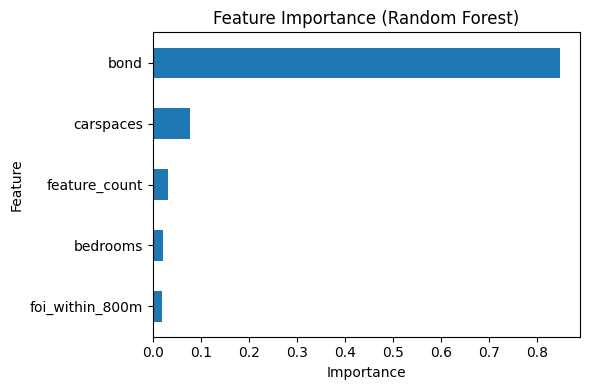

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the dataset
df = pd.read_csv("/Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/raw/8. domain/domain with FOI COUNTS/domain_with_foi_counts.csv")

# Create feature_count from binary property features
binary_features = [
    "balcony", "car_parking", "heating", "air_conditioning", "built_in_wardrobes",
    "swimming_pool", "ensuite", "dishwasher", "garden", "gym", "pets_allowed",
    "gas", "intercom", "security_system", "washing_machine"
]
df["feature_count"] = df[binary_features].sum(axis=1)

# Compute foi_total (sum of all FOI types across 3 distance bands)
foi_columns = [
    "cultural_200m", "education_200m", "health_200m", "others_200m", "tourist_200m",
    "cultural_400m", "education_400m", "health_400m", "others_400m", "tourist_400m",
    "cultural_800m", "education_800m", "health_800m", "others_800m", "tourist_800m"
]
df["foi_total"] = df[foi_columns].sum(axis=1)

# Define feature columns
feature_columns = [
    "feature_count", "bedrooms", "bathrooms", "carspaces", "bond",
    "foi_within_200m", "foi_within_400m", "foi_within_800m", "foi_total"
]

# Drop missing values
df_rfe = df[feature_columns + ["weekly_rent"]].dropna()

# Split into X (features) and y (target)
X = df_rfe[feature_columns]
y = df_rfe["weekly_rent"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initialize and fit RFE with Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rfe = RFE(estimator=rf, n_features_to_select=5)
rfe.fit(X_train, y_train)

# Output results
selected_features = X.columns[rfe.support_]
ranking = pd.Series(rfe.ranking_, index=X.columns).sort_values()

print("Top 5 selected features:")
print(list(selected_features))

print("\nFull RFE feature ranking:")
print(ranking)

# Predict on test set
from sklearn.metrics import r2_score, mean_absolute_error

# Use only the top 5 selected features for X_test
X_test_selected = rfe.transform(X_test)

# Predict using the trained Random Forest from RFE
y_pred = rfe.estimator_.predict(X_test_selected)

# Evaluate model performance
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("🔍 Model Evaluation Using Top 5 Features:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")

# Visualize Feature Importance

import matplotlib.pyplot as plt

importances = pd.Series(
    rfe.estimator_.feature_importances_,
    index=X.columns[rfe.support_]
)
plt.figure(figsize=(6, 4))
importances.sort_values().plot(kind="barh", title="Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



feature importance non linear external


🔍 Top selected features (external):
['average_income', 'mortgage_repayments', 'foi_count']

Full external feature ranking:
average_income           1
mortgage_repayments      1
foi_count                1
Predicted_Income_2025    2
tenant_rate              3
dtype: int64

 Model Evaluation Using Selected External Features:
R² Score: 0.4939
Mean Absolute Error (MAE): $60.95


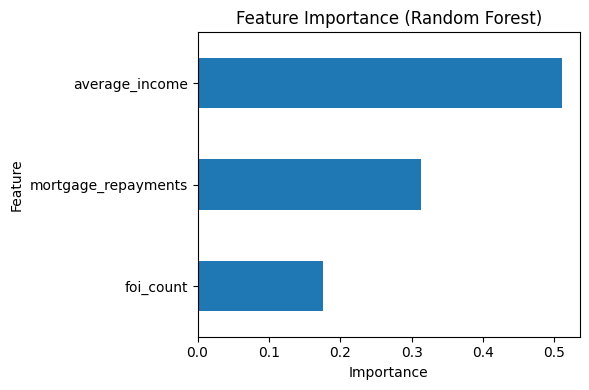

In [ ]:
# import Libraries
import pandas as pd
import geopandas as gpd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# SA2-level median rent
rentals = pd.read_csv(
    "/Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/raw/sa2_rent.csv"
)
rentals["median_rent"] = pd.to_numeric(rentals["median_rent"], errors="coerce")

# Crime dataset
crime = pd.read_csv(
    "/Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/raw/crime_dataset.csv"
)

# Demographics dataset
demographics = pd.read_csv(
    "/Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/raw/demographics_dataset.csv"
)

# Predicted income dataset
income = pd.read_csv(
    "/Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/raw/predicted_income_till_2030.csv"
)

# FOI (Points of Interest / amenities)
foi = gpd.read_file(
    "/Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/raw/services_amenities_vic/foi_points_cleaned.shp"
)

## POPULATION and pt stosps next######################

# Normalize SA2 Codes Across All Datasets

def normalize_sa2(df, col="SA2"):
    df[col] = df[col].astype(str).str.split(".").str[0].str.zfill(9)
    return df

rentals = normalize_sa2(rentals)
crime = crime.rename(columns={"SA2_CODE21": "SA2"})
crime = normalize_sa2(crime)
income = normalize_sa2(income.rename(columns={"SA2": "SA2"}))

# Suburb → SA2 mapping (for demographics)
suburb_sa2_map = pd.read_csv(
    "/Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/raw/mapped_target_suburbs.csv"
).rename(columns={"SA2_CODE21": "SA2"})
suburb_sa2_map = normalize_sa2(suburb_sa2_map)

# Merge demographics with SA2 mapping
demographics_sa2 = demographics.merge(
    suburb_sa2_map[["Target_Suburb", "SA2"]],
    on="Target_Suburb",
    how="left"
)
demographics_sa2 = normalize_sa2(demographics_sa2)

# FOI (Amenities) — Spatial Join to SA2
sa2 = gpd.read_file(
    "/Users/ariqasri/Desktop/project-2-group-real-estate-industry-project-7-2025/ariqasri-workspace/dataset/landing/SA2_GDA2020_SHAPEFILE/SA2_2021_AUST_GDA2020.shp"
)
sa2_vic = sa2[sa2["STE_CODE21"] == "2"].copy().to_crs("EPSG:4283")

foi = foi.to_crs(sa2_vic.crs)
foi_sa2 = gpd.sjoin(foi, sa2_vic, how="left", predicate="within")

# Aggregate FOI counts by SA2
if "SA2_CODE21" in foi_sa2.columns:
    foi_sa2 = foi_sa2.rename(columns={"SA2_CODE21": "SA2"})
elif "SA2_CODE21_right" in foi_sa2.columns:
    foi_sa2 = foi_sa2.rename(columns={"SA2_CODE21_right": "SA2"})

foi_counts = foi_sa2.groupby("SA2").size().reset_index(name="foi_count")


# Merge All Datasets into One 

year = 2025

merged = (
    rentals
    .merge(
        crime[["SA2", f"Incidents_{year}", f"CrimeRate_{year}",
                f"Victims_{year}", f"VictimRate_{year}"]],
        on="SA2", how="left"
    )
    .merge(
        demographics_sa2[["SA2", "average_income", "mortgage_repayments", "tenant_rate"]],
        on="SA2", how="left"
    )
    .merge(
        income[["SA2", "Predicted_Income_2025"]],
        on="SA2", how="left"
    )
    .merge(
        foi_counts,
        on="SA2", how="left"
    )
)

# Feature Selection Setup

external_features = [
    "average_income",
    "mortgage_repayments",
    "tenant_rate",
    "Predicted_Income_2025",
    "foi_count"
]
target = "median_rent"

# Drop missing values
df_external = merged[external_features + [target]].dropna()

X = df_external[external_features]
y = df_external[target]

# Train/Test Split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Recursive Feature Elimination (RFE) + Random Forest

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rfe = RFE(estimator=rf, n_features_to_select=3)
rfe.fit(X_train, y_train)

selected_features = list(X.columns[rfe.support_])
ranking = pd.Series(rfe.ranking_, index=X.columns).sort_values()

print("🔍 Top selected features (external):")
print(selected_features)

print("\nFull external feature ranking:")
print(ranking)

# Evaluate Model Performance

from sklearn.metrics import r2_score, mean_absolute_error

X_test_selected = rfe.transform(X_test)
y_pred = rfe.estimator_.predict(X_test_selected)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\n Model Evaluation Using Selected External Features:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")

# Visualize Feature Importance

import matplotlib.pyplot as plt

importances = pd.Series(
    rfe.estimator_.feature_importances_,
    index=X.columns[rfe.support_]
)
plt.figure(figsize=(6, 4))
importances.sort_values().plot(kind="barh", title="Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
